# Deflection-Profile Verification
This file verifies the Deflection-Profile implementation provided in the file "deflection_profile.py" of the bmcs_beam package.

In [1]:
%matplotlib widget
# %matplotlib qt

In [2]:
from bmcs_cross_section.api import MKappa, TShape, MKappaParamsStudy, EC2, ReinfLayer, IShape, CustomShape
from bmcs_beam.api import BoundaryConditions, BoundaryConfig, DeflectionProfile, BeamDesign, LoadDeflectionParamsStudy
from os.path import join
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import bmcs_utils.api as bu

In [3]:
#def plot(mc):
#     fig, ax = plt.subplots(1, 1)
#     dp = DeflectionProfile(mc=mc)
#     F, w = dp.get_Fw()
#     ax.plot(w, F / 1000, c= 'blue', label= 'bmcs_deflection'); ax.legend()
#     ax.set_xlabel(r'$w$ [mm]')
#     ax.set_ylabel(r'$F$ [kN]')
#     plt.show()

def plot_fw_ver(mc, ver_data, data, L, mode, f_coef):
    
    # mode: 'multi' to plot multiple experiments and 'one' to plot one experiment
    # f_coef: a coeficient for the 'F' values of the experiment based on the experiment configuration;
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
    ax1.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    dp.mc.plot_mk(ax1)
    dp.plot_fw(ax2)
    if mode == 'multi':
        for i in range(0,data.shape[1],2):
            ax2.plot(data.iloc[:, i+1],data.iloc[:, i] * f_coef, label = data.columns.tolist()[i][0:-2] , alpha=0.5)
        ax2.plot([L/250 , L/250], [0, max(data.iloc[:, 2]) * f_coef],  c='black', ls= '--' ); plt.annotate('L/500', xy=(L/500, max(data.iloc[:, 2]) * f_coef))
        ax2.plot([L/500 , L/500], [0, max(data.iloc[:, 2]) * f_coef],  c='black', ls= ':' ); plt.annotate('L/250', xy=(L/250, max(data.iloc[:, 2]) * f_coef))
    
    else:
        w = ver_data[0]
        f = ver_data[1]
        ax2.plot(w, f * f_coef, c= 'red', label= 'Experiment')
        ax2.plot([L/250 , L/250], [0, max(f) * f_coef],  c='black', ls= '--' ); plt.annotate('L/500', xy=(L/500, max(f) * f_coef))
        ax2.plot([L/500 , L/500], [0, max(f) * f_coef],  c='black', ls= ':' ); plt.annotate('L/250', xy=(L/250, max(f) * f_coef))
    ax2.legend()
    
    return fig


def plot_fw_ver_on_ax(ax, dp, ver_data):
    ax.set_xlabel('Deflection [mm]')
    ax.set_ylabel('Force [kN]')
    dp.plot_fw(ax)
    ax.plot(ver_data[0], ver_data[1])
    ax.legend()
    
def interact(dp):
    dp.interact()

def make_simulation(high_kappa,E,f_cm,mu,B,H,material,E_reinforcement,system,L,L_F,
                    z=False,alpha=False,A=False,rho=False,f_t=False,f_sy=False,f_ctm=False,eps_cr=False,beta_tu=False):
    
    if z==False:
        z=H * (1 - alpha)
        print('z= '+str(z))
    if A==False:
        A=A=rho * B * alpha * H
        print('A= '+str(A))
    if eps_cr==False:
        eps_cr=f_ctm/E
        print('eps_cr= '+str(eps_cr))
    if beta_tu==False:
        eps_tu = f_ctm/E
        print('eps_tu= '+str(eps_tu))
    else:
        eps_tu = beta_tu * eps_cr
        print('eps_tu= '+str(eps_tu))

    
    mc = MKappa(low_kappa = 0, high_kappa = high_kappa)
    mc.cs_design.matrix='EC2'
    mc.cs_design.matrix_.trait_set(
        E_cc=E,
        E_ct=E,
        eps_cr=f_ctm/E,
        eps_tu=f_ctm/E,
        mu=0.0,
        f_cm = f_cm
    )
    mc.cross_section_shape_.B = B
    mc.cross_section_shape_.H = H
        
    bl1 = ReinfLayer(name=material, z=z, A=A, matmod=material)
    if material == 'carbon':
        bl1.matmod_.trait_set(E=E_reinforcement,f_t=f_t,factor = 1.)
    if material == 'steel':
        bl1.matmod_.trait_set(E_s=E_reinforcement, f_sy=f_sy)
    mc.cross_section_layout.add_layer(bl1)
    
    dp = DeflectionProfile(mc=mc)
    dp.beam_design.system = system
    dp.beam_design.system_.L = L
    dp.beam_design.system_.L_F = L_F
    
    return dp
    
def get_data_ghadioui():
    excel_file = join('../verification_data/el_ghadioui2020', 'fig_3.xlsx')
    data = pd.read_excel(excel_file, engine='openpyxl')
    
    return data

## 1. Checking the model with its default parameters

In [4]:
dp = DeflectionProfile()
bl1 = ReinfLayer()
dp.mc.cross_section_layout.add_layer(bl1)

interact(dp)

## 2. Verification with experimental results

### Verification with Rectangluar cross sections

**1. El Ghadioui2020: Structural behaviour of CFRP reinforced concrete members under bending and shear loads**

In [9]:
#_, (ax_el) = plt.subplots()

eps_cr= 4.116331096196868e-05
eps_tu= 4.116331096196868e-05


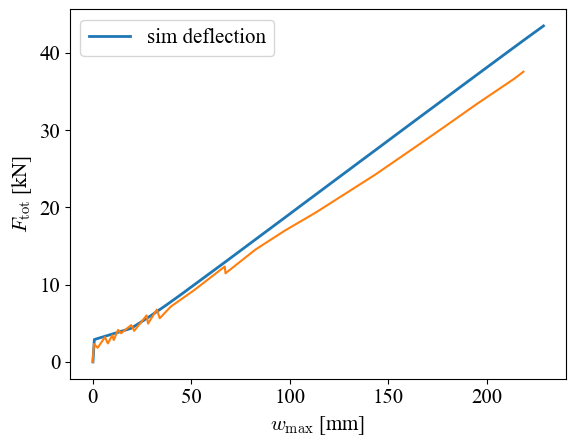

In [5]:
# Beam B-M-C-K1 - CFRP Bars (C 50/60)

data = get_data_ghadioui()
ver_data = [data['B-M-C-K1_deflection'], data['B-M-C-K1_load']]

dp = make_simulation(high_kappa=0.00011,E=33525,f_cm=64.4,f_ctm=(0.3*4.6),mu=0.0,B=400,H=200,
                     material='carbon',z=35,A=(2*70.14),E_reinforcement=135121,f_t=1891,
                     system='4pb',L=4700,L_F=1925)
dp.mc.n_kappa = 1000
fig, (ax1) = plt.subplots()
plot_fw_ver_on_ax(ax1, dp, ver_data)
# dp.interact()
fig

eps_cr= 6.860551826994779e-05
eps_tu= 6.860551826994779e-05


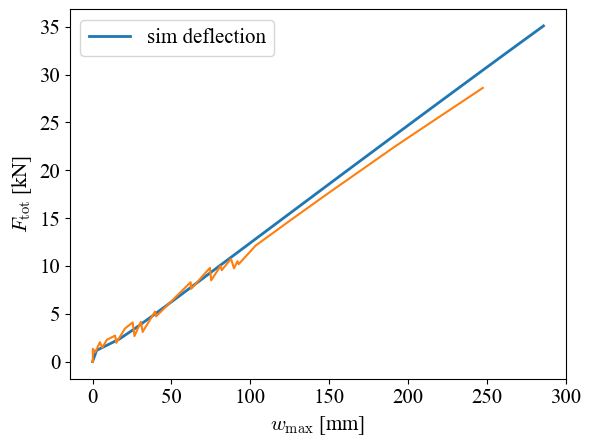

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
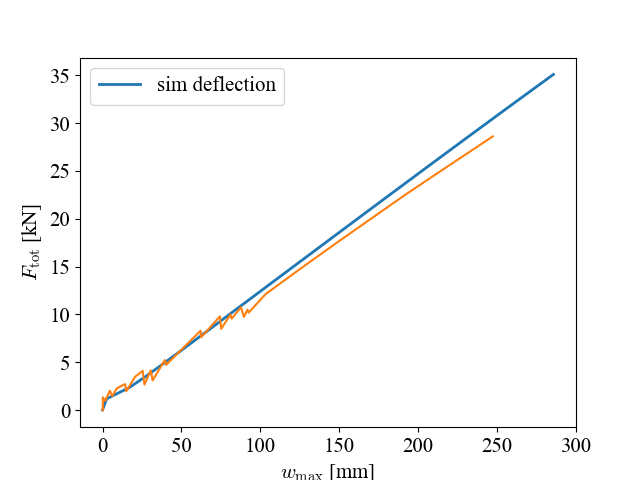

In [7]:
# Beam B-M-C-K2 - CFRP Bars (C 50/60)

data = get_data_ghadioui()
ver_data = [data['B-M-C-K2_deflection'], data['B-M-C-K2_load']]

dp = make_simulation(high_kappa=0.00015,E=33525,f_cm=64.4,f_ctm=(0.5*4.6),mu=0.0,B=400,H=200,
                     material='carbon',z=66,A=(2*70.14),E_reinforcement=135121,f_t=1891,
                     system='4pb',L=4700,L_F=1925)

fig, (ax1) = plt.subplots()
plot_fw_ver_on_ax(ax1, dp, ver_data)
fig

eps_cr= 6.860551826994779e-05
eps_tu= 6.860551826994779e-05


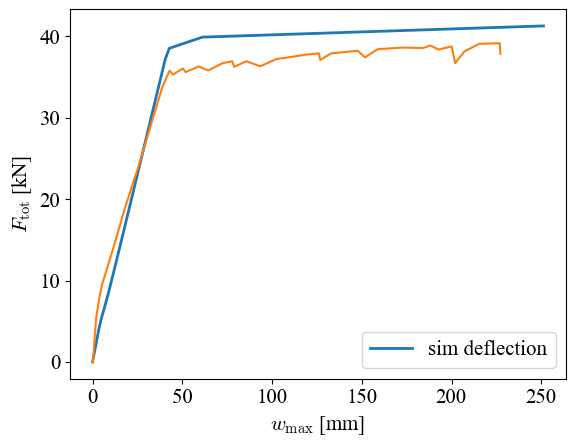

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
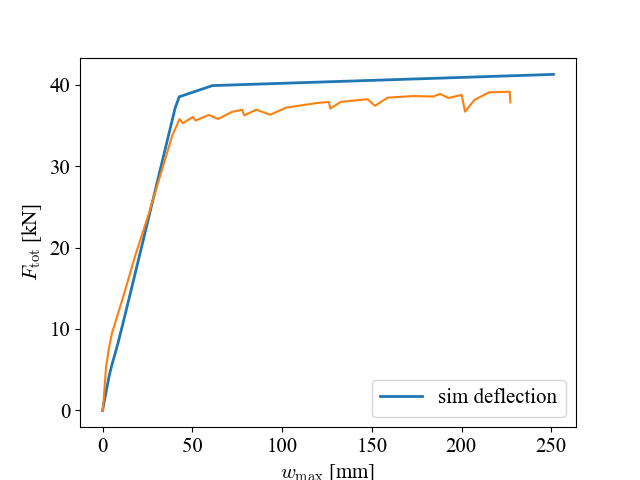

In [8]:
# Beam B-M-S-K1 - Steel Bars (C 50/60)

data = get_data_ghadioui()
ver_data = [data['B-M-S-K1_deflection'], data['B-M-S-K1_load']]

dp = make_simulation(high_kappa=0.00017,E=33525,f_cm=64.4,f_ctm=(0.5*4.6),mu=0.0,B=400,H=200,
                     material='steel',z=19,A=(4 * np.pi * (12/2)**2),E_reinforcement=200000,f_sy=500,
                     system='4pb',L=4700,L_F=1925)

fig, (ax1) = plt.subplots()
plot_fw_ver_on_ax(ax1, dp, ver_data)
fig

eps_cr= 0.00010882639326421902
eps_tu= 0.00010882639326421902


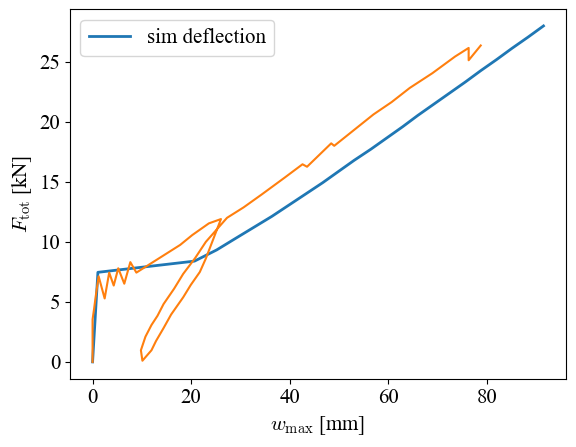

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
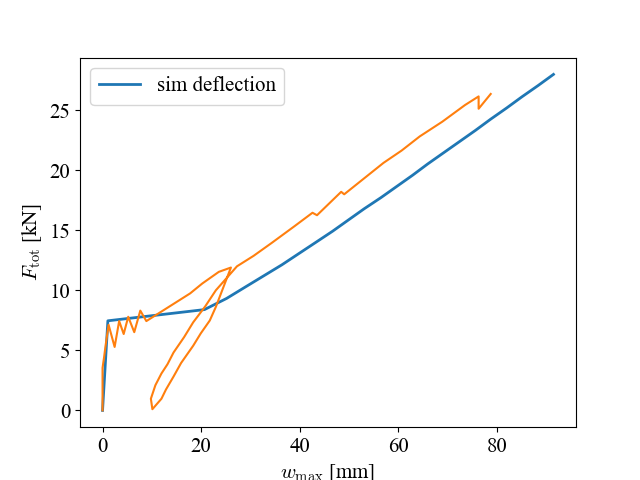

In [9]:
# Beam A-M-C-K1 - Grid (C 40/50)

data = get_data_ghadioui()
ver_data = [data['A-M-C-K1_deflection'], data['A-M-C-K1_load']]

dp = make_simulation(high_kappa=0.00021,E=34918,f_cm=52.9,f_ctm=(0.95*4),mu=0.0,B=500,H=105,
                     material='carbon',z=21,A=106.68,E_reinforcement=108606,f_t=1429,
                     system='4pb',L=2200,L_F=870)

fig, (ax1) = plt.subplots()
plot_fw_ver_on_ax(ax1, dp, ver_data)
fig

#### 2. Papanicolaou et al. (2010), [link](https://www.jstage.jst.go.jp/article/jact/8/1/8_1_35/_article), steel reinforced section strengthened by carbon textile
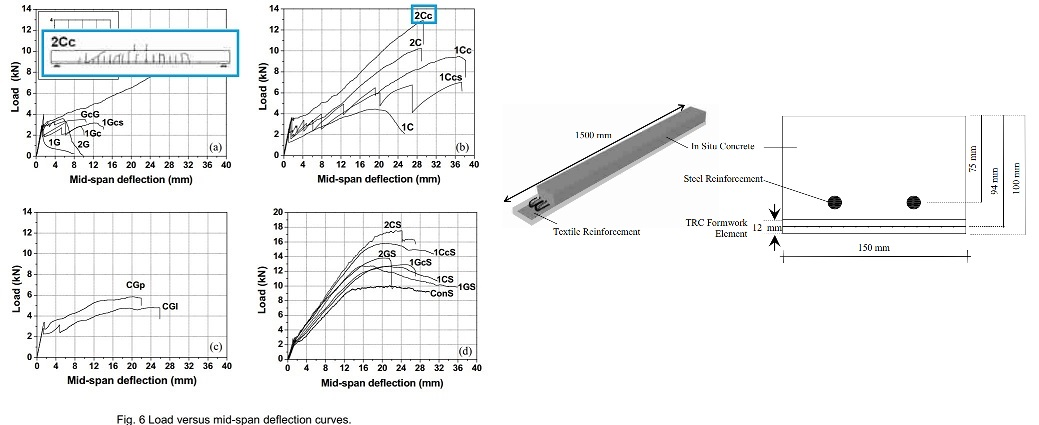

In [12]:
#2Cc
excel_file = join('../verification_data/pap10','pap10.xlsx')
data = pd.read_excel(excel_file, '2Cc', engine='openpyxl')

for i in range(0,data.shape[1],2):
    plt.plot(data.iloc[:, i+1], data.iloc[:, i], label = data.columns.tolist()[i][0:-2])
w_1= data['2Cc_w']
f_1= data['2Cc_F']
ver_data1 = [w_1, f_1]
#plt.plot(w_1,f_1, label = '2Cc')
plt.legend()
plt.xlabel(r'$w$ [mm]')
plt.ylabel(r'$F$ [KN]')

Text(54.902777777777786, 0.5, '$F$ [KN]')

In [14]:
# 2Cc

dp = make_simulation(high_kappa=0.0001,E=30000,f_cm=64.4,mu=0.0,B=150,H=100,material='carbon',E_reinforcement=225000,
                     system='4pb',L=(3*650),L_F=800,
                    alpha=0.94,rho=(0.0079*2*150*12)/(150*100),f_sy=3350,eps_cr=0.00016,beta_tu=2)
# f_cm = 64.4 (Annahme von mir)
# L_F = 800 (Annahme von mir)


# mc = MKappa(n_m=100, n_kappa = 100) #? ((6.365 + 6.306 + 5.635 + 5.627 + 5.452 + 5.627)/6)/E = 100
# mc = MKappa(reinforcement_type= ReinforcementType.CARBON)
# dp = DeflectionProfile(mc=mc)
# dp.mc.low_kappa = 0
# dp.mc.high_kappa = 0.0001

# # Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
# dp.beam_design.beam_conf_name = BoundaryConfig.FOUR_PB

dp.beam_design.L = 3 * 650

# map_and_assign_params_for_rectangular_section(dp.mc,
#             beta_tu = 2,  #  eps_tu/eps_cr
#             b = 150,
#             h = 100,
#             rho = (0.0079 * 2 * 150 * 12) / (150 * 100),
#             v_f = 0.0,
#             E = 30000,
#             E_s = 225000, 
#             f_sy = 3350 , 
#             eps_cr = 0.00016, # how to calculate it?! 
#             omega = .68, #eps_cy/eps_cr
#             psi = 0.0148/0.00016, #eps_sy_j/eps_cr
#             mu = 0.0, #σp/σcr
#             alpha = .94, #z_j/h
#             lambda_cu = 21.93) #eps_cu/eps_cr

# # dp.mc.A_j = np.array([3.62, 3.62])  # A_j[0] for tension steel / A_j[1] for compression steel
# # dp.mc.z_j = np.array([8, 22])
# # dp.mc.E_j = np.array([240000, 240000])
# # dp.mc.eps_sy_j = np.array([0.0135, 0.0135])

# plot_fw_ver(dp.mc, ver_data1 ,data, dp.beam_design.L, mode = 'one', f_coef = 0.5)
# fig, (ax1) = plt.subplots()
# plot_fw_ver_on_ax(ax1, dp, ver_data1)

interact(dp)

z= 6.000000000000005
A= 26.733600000000003
eps_tu= 0.00032
V_Rm_c = 9.39 kN, Shear failure by F_tot_max = 18.78 kN


#### 3. Verification with Bielak (2019), https://doi.org/10.3390/app9071382, Carbon reinforcement
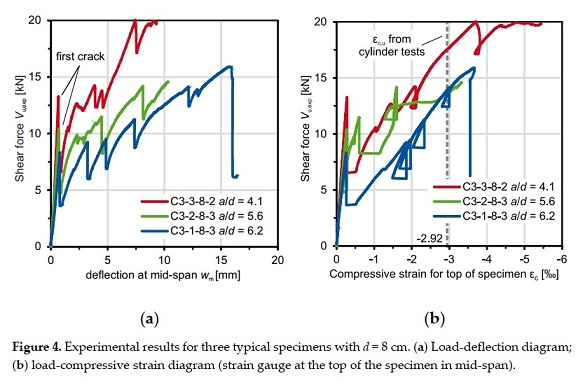

In [15]:
excel_file = join('../verification_data/bie19','bie19.xlsx')
data = pd.read_excel(excel_file, engine='openpyxl')
for i in range(0,data.shape[1],2):
    plt.plot(data.iloc[:, i+1],data.iloc[:, i], label = data.columns.tolist()[i][0:-2]);plt.legend()
w_= data['C3-3-8-2_w']  ; f_= data['C3-3-8-2_F'] ; ver_data = [w_, f_]; #plt.plot(w_,f_, label = 'C3-3-8-2')
w_1= data['C3-2-8-3_w']  ; f_1= data['C3-2-8-3_F'] ; ver_data1 = [w_1, f_1]; #plt.plot(w_1,f_1, label = 'C3-2-8-3')
w_2= data['C3-1-8-3_w']  ; f_2= data['C3-1-8-3_F'] ; ver_data2 = [w_2, f_2]; #plt.plot(w_2,f_2, label = 'C3-1-8-3')

plt.legend(); plt.xlabel(r'$w$ [mm]'); plt.ylabel(r'$F$ [KN]');

In [16]:
# C3-3-8-2

mc = MKappa(n_m=100, n_kappa = 100)
mc = MKappa(reinforcement_type= ReinforcementType.CARBON)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.0008
# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConfig.THREE_PB

dp.beam_design.L = 2 * 320

map_and_assign_params_for_rectangular_section(dp.mc,
            beta_tu = 2,  #  eps_tu/eps_cr
            b = 200,
            h = 99,
            rho = 0.00234,
            v_f = 0.0,
            E = 44429,
            E_s = 244835, #Warp:244835, Weft:243828
            f_sy = 2737 , #Warp:3221, Weft:3334
            eps_cr = 0.0002616,
            omega = 0.28/0.2616, #eps_cy/eps_cr
            psi = 13.2/0.2616, #eps_sy_j/eps_cr
            mu = 0.2, #σp/σcr
            alpha = 0.77, #z_j/h
            lambda_cu = 2.92/0.2616) #eps_cu/eps_cr

plot_fw_ver(dp.mc, ver_data ,data, dp.beam_design.L, mode = 'one', f_coef =2 )

# interact(dp)

NameError: name 'ReinforcementType' is not defined

#### 3. Von der Heid et al. (2020), [link](https://www.heringinternational.com/fileadmin/media/archive1/downloads/architekturbeton/Bauingenieur_06_2020_S.210-219.pdf), Carbon reinforcement
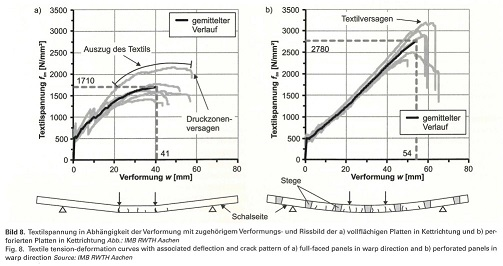

HB-SU-0:
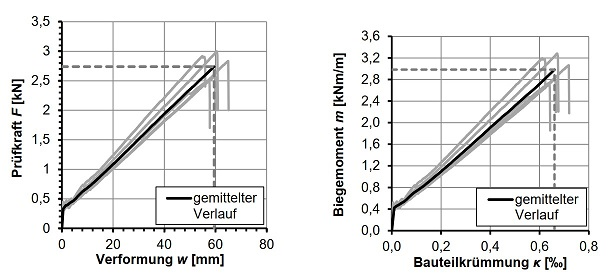

In [ ]:
#HB-SU-0
excel_file = join(../verification_data/hei20','hei20.xlsx')
data = pd.read_excel(excel_file, 'HB-SU-0', engine='openpyxl')

for i in range(0,data.shape[1],2):
    plt.plot(data.iloc[:, i+1],data.iloc[:, i], label = data.columns.tolist()[i][0:-2])
w_1= data['HB-SU-0-1_w']  ; f_1= data['HB-SU-0-1_F'] ; ver_data1 = [w_1, f_1/4];
w_2= data['HB-SU-0-2_w']  ; f_2= data['HB-SU-0-2_F'] ; ver_data2 = [w_2, f_2/4];
w_3= data['HB-SU-0-3_w']  ; f_3= data['HB-SU-0-3_F'] ; ver_data3 = [w_3, f_3/4];
w_4= data['HB-SU-0-4_w']  ; f_4= data['HB-SU-0-4_F'] ; ver_data4 = [w_4, f_4/4];
w_5= data['HB-SU-0-5_w']  ; f_5= data['HB-SU-0-5_F'] ; ver_data5 = [w_5, f_5/4];
w_6= data['HB-SU-0-6_w']  ; f_6= data['HB-SU-0-6_F'] ; ver_data6 = [w_6, f_6/4];
plt.legend(); plt.xlabel(r'$w$ [mm]'); plt.ylabel(r'$F$ [KN]');

In [ ]:
# HB-SU-0

# from tensile test
# eps_cr = (0.000071870052 + 0.000073223436 + 0.000076332606 + 0.000064518618)/4

# from bending test from ε_c,Riss
# eps_cr = (0.00023 + 0.00097 + 0.00047 + 0.00129 + 0.00182 + 0.00102)/6

# E = 35786.7
E = 39500

# from bending test from σ_c,Riss
eps_cr = ((6.365 + 6.306 + 5.635 + 5.627 + 5.452 + 5.627)/6)/E

mc = MKappa(reinforcement_type= ReinforcementType.CARBON,
            low_kappa = 0,
            high_kappa = 0.0007,
            E_cc = E,
            E_ct = E,
            eps_cr = eps_cr, # 0.000163
            eps_tu = 9.02/E, # beta_tu = 20
            eps_cy = 72/E, # omega = 10.0
            eps_cu = (72/E)*2, # lambda_cu = 20
            mu = 0.0)

mc.cross_section_shape.B = 45
mc.cross_section_shape.H = 30
mc.cross_section_layout.reinforcement = [Reinforcement(eps_sy=2712/240000, E=240000, z=8, A=3.62),
                                         Reinforcement(eps_sy=2712/240000, E=240000, z=22, A=3.62),]

dp = DeflectionProfile(mc=mc)

dp.beam_design.beam_conf_name = BoundaryConfig.FOUR_PB
dp.beam_design.beam_conf_name.first_load_distance = 320
dp.beam_design.L = 840

fig = plot_fw_ver(dp.mc, ver_data1 ,data, dp.beam_design.L, mode = 'multi', f_coef = 0.25)

# fig.savefig('von der Heid et al._2020_HB-SU-0.pdf') 

# interact(dp)

HB-SU-90:
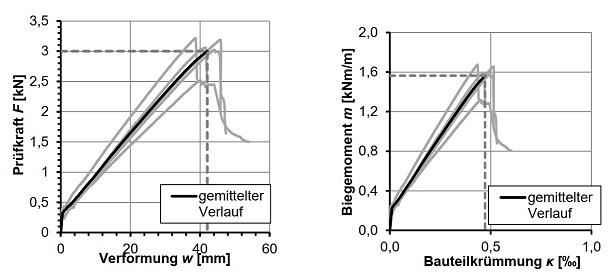

In [ ]:
# HB-SU-90
# Import data
excel_file = join(../verification_data/hei20','hei20.xlsx')
data = pd.read_excel(excel_file, 'HB-SU-90', engine='openpyxl')
w_data= [data['HB-SU-90-1_w'], data['HB-SU-90-2_w'], data['HB-SU-90-3_w'], data['HB-SU-90-4_w'], data['HB-SU-90-5_w']]
f_data= [data['HB-SU-90-1_F'], data['HB-SU-90-2_F'], data['HB-SU-90-3_F'], data['HB-SU-90-4_F'], data['HB-SU-90-5_F']]
# Dividing by 4 because in Anni test the force is F/2, also here we are taking half cross section so half that force
f_data = [data/4 for data in f_data] 

In [ ]:
# HB-SU-90
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.set_xlabel(r'$w$ [mm]')
ax1.set_ylabel(r'$F$ [KN]')

for w, f in zip(w_data, f_data):
    ax1.plot(w, f, label= 'Exp', alpha=0.6)

ax1.legend()

# E = 35786.7
E = 39500

# from bending test from σ_c,Riss
eps_cr = ((5.84 + 6.28 + 5.72 + 4.33)/4)/E

mc = MKappa(reinforcement_type= ReinforcementType.CARBON,
            low_kappa = 0,
            high_kappa = 0.0004,
            E_cc = E,
            E_ct = E,
            eps_cr = eps_cr, # 0.000163
            eps_tu = 9.3/E, # beta_tu = 20
            eps_cy = 72/E, # omega = 10.0
            eps_cu = (72/E)*2, # lambda_cu = 20
            mu = 0.0)

mc.cross_section_shape.B = 45
mc.cross_section_shape.H = 30
mc.cross_section_layout.reinforcement = [Reinforcement(eps_sy=1385/240000, E=240000, z= 8, A=2*3.62),
                                         Reinforcement(eps_sy=1385/240000, E=240000, z=22, A=2*3.62)]

dp = DeflectionProfile(mc=mc)

dp.beam_design.beam_conf_name = BoundaryConfig.FOUR_PB
dp.beam_design.beam_conf_name.first_load_distance = 320
dp.beam_design.L = 840

# fig = plot_fw_ver(dp.mc, ver_data1 ,data, dp.beam_design.L, mode = 'multi', f_coef = 0.25)

# dp.mc.plot_mk(ax2)
# dp.plot_fw(ax1)

# interact(dp)

#### 4. Ahmed et al. 2019 https://www.sciencedirect.com/science/article/abs/pii/S0950061819326376

In [10]:
# Beam C05-GPC35

# # Import data
# excel_file = join(../verification_data/hei20','hei20.xlsx')
# data = pd.read_excel(excel_file, 'HB-SU-90', engine='openpyxl')
# w_data= [data['HB-SU-90-1_w'], data['HB-SU-90-2_w'], data['HB-SU-90-3_w'], data['HB-SU-90-4_w'], data['HB-SU-90-5_w']]
# f_data= [data['HB-SU-90-1_F'], data['HB-SU-90-2_F'], data['HB-SU-90-3_F'], data['HB-SU-90-4_F'], data['HB-SU-90-5_F']]
# # Dividing by 4 because in Anni test the force is F/2, also here we are taking half cross section so half that force
# f_data = [data/4 for data in f_data] 

# fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
# ax1.set_xlabel(r'$w$ [mm]')
# ax1.set_ylabel(r'$F$ [KN]')

# for w, f in zip(w_data, f_data):
#     ax1.plot(w, f, label= 'Exp', alpha=0.6)

# ax1.legend()


E = 29894

mc = MKappa(reinforcement_type= ReinforcementType.CARBON,
            
#             concrete_material_law = ConcreteMaterialLaw.EC2,
# #             f_cm = 33.87,
#             f_cd = 33.87,
            
            low_kappa = 0,
            high_kappa = 0.00006,
            E_cc = E,
            E_ct = E,
            eps_cr = 2.431/E, # 0.000163
            eps_tu = 10 * 2.431/E, # beta_tu = 20
            eps_cy = 0.002, # EC2, #33.87/E
            eps_cu = 0.0035, # EC2, # (33.87/E)*2
            mu = 0.0)

mc.cross_section_shape.B = 110
mc.cross_section_shape.H = 300
mc.cross_section_layout.reinforcement = [Reinforcement(eps_sy=2000/148000, E=148000, z= 25, A=3*np.pi*(6/2)**2)]

dp = DeflectionProfile(mc=mc)

dp.beam_design.beam_conf_name = BoundaryConfig.FOUR_PB
dp.beam_design.beam_conf_name.first_load_distance = 800
dp.beam_design.L = 2000
dp.F_scale = 2/1000
# fig = plot_fw_ver(dp.mc, ver_data1 ,data, dp.beam_design.L, mode = 'multi', f_coef = 0.25)

# dp.mc.plot_mk(ax2)
# dp.plot_fw(ax1)

interact(dp)

NameError: name 'ReinforcementType' is not defined

#### 5. Yang et al. (2010), http://dx.doi.org/10.1016/j.engstruct.2010.07.017, Steel reinforcement

### Verification with I-sections

#### 1. Bielak (2020), http://dx.doi.org/10.3390/app10134625 , Carbon textiles+bars

In [6]:
# Beam FT01 - CFRP Bars + textile
E = 38750

# fctk_0_05 = EC2.get_f_ctk_0_05(f_ck)
# f_ctd = fctk_0_05
# # f_ctd = 0.85 * fctk_0_05 / 1.5
# f_ctd_fl = max((1.6 - h /1000) * f_ctd, f_ctd)

f_ct = 5.58
f_cm = 98.8
f_ck = f_cm - 8

mc = MKappa(low_kappa = 0, high_kappa = 0.000015, n_m=1000) # high_kappa = 0.000015
# mc.cs_design.matrix= 'EC2 with plateau' # 'piecewise linear'
mc.cs_design.matrix_.trait_set(
        E_cc=E,
        E_ct=E,
        eps_cr= f_ct/E, # 0.000125, #12.29/E,
#         eps_cy=EC2.get_eps_c2(f_ck),
#         eps_cu=EC2.get_eps_cu2(f_ck),
#         eps_cy=0.00175,
#         eps_cu=0.0035,
#         eps_tu=0.002,
        mu=0.0,
        f_cd = f_cm
    )

mc.cross_section_shape = 'I-shape'
mc.cross_section_shape_.H = 900

# Approximating the contribution of glass grid
# textile1 = ReinfLayer(name='Glass grid', z=75, A=10 * 4.62, matmod='carbon')
# textile1.matmod_.trait_set(E=70843, f_t=1590)
# mc.cross_section_layout.add_layer(textile1)

# bl1 = ReinfLayer(name='layer1', z=30, A=5 * np.pi * (9.5/2)**2 + 4 * 3.62, matmod='carbon')
bl1 = ReinfLayer(name='layer1', z=30, A=5 * np.pi * (9.5/2)**2, matmod='carbon')
bl1.matmod_.trait_set(E=165515, f_t=1828)
mc.cross_section_layout.add_layer(bl1)


# bl2 = ReinfLayer(name='layer2', z=75, A=10 * 4.62, matmod='carbon')
# bl2.matmod_.trait_set(E=70843, f_t=1828)
# mc.cross_section_layout.add_layer(bl2)

# If reinforcement would've been steel ->
# bl1 = ReinfLayer(name='layer1', z=30, A=5 * np.pi * (9.5/2)**2, matmod='steel')
# bl1.matmod_.trait_set(E_s=200000, f_sy=500)
# mc.cross_section_layout.add_layer(bl1)


dp = DeflectionProfile(mc=mc)

dp = DeflectionProfile(mc=mc)
dp.beam_design.system = 'simple_beam_dist_load'
dp.beam_design.system_.L = 7000

dp.interact()

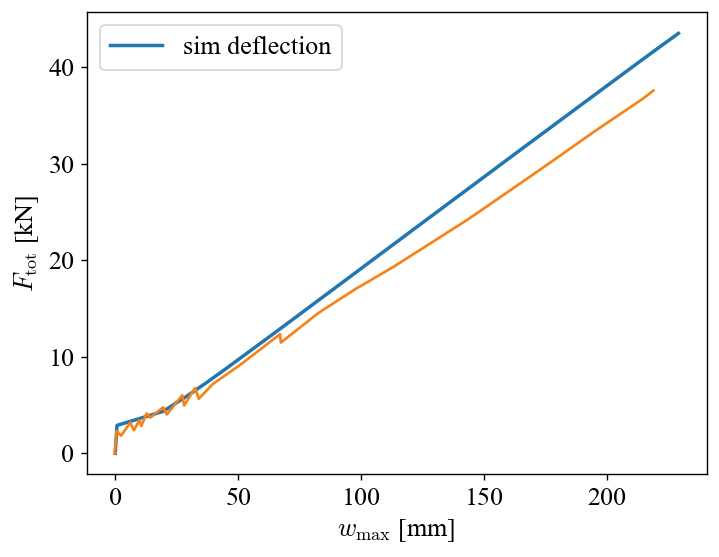

In [8]:
# Compare with experimental results
path = join('..', 'verification_data', 'Bie20', 'FT01.csv')
exp_deflection_load = np.array(pd.read_csv(path, delimiter=';', decimal='.')).T
exp_deflection = exp_deflection_load[0]
exp_load = exp_deflection_load[1]

_, (ax) = plt.subplots()
ax.plot(exp_deflection, exp_load)

Fw = dp.get_Fw()
F = Fw[0] * dp.final_plot_F_scale
w = Fw[1]
ax.plot(w, F)
fig
# ax.figure.savefig('bielak2.pdf')

### Verification with T-sections

#### 1. Abdul-Ahad and Aziz (1999), https://doi.org/10.1002/suco.201500191, Steel reinforcement
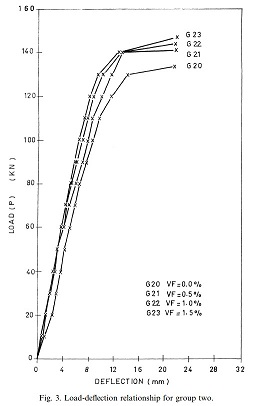

In [ ]:
excel_file = join(../verification_data/yao20_yao_mobasher/figure_14', 'abd99.xlsx') # G 23 line
data = pd.read_excel(excel_file, engine='openpyxl')
w_= data['G23_w'] ; f_= data['G23_F'] ; ver_data = [w_, f_]; plt.plot(w_,f_, label = 'G 23')
plt.legend(); plt.xlabel(r'$w$ [mm]'); plt.ylabel(r'$F$ [kN]');

In [ ]:
# G 23
mc = MKappa(n_m=100, n_kappa = 100)
mc = MKappa(reinforcement_type= ReinforcementType.STEEL)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.00005
# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConfig.FOUR_PB

dp.beam_design.L = 1800 

map_and_assign_params_for_t_section(dp.mc,
            beta_tu = 15, 
            b = 250,
            h = 210,
            rho = 0.0209,
            v_f = 0.02,
            E = 20400,
            E_s = 200000,
            f_sy = 465,
            eps_cr = 0.000210,
            omega = 5.9,
            psi = 11.1,
            mu = 0.3,
            alpha = 0.81,
            o = 0.4, 
            zeta = 0.29,
            lambda_cu = 40.9)

plot_fw_ver(dp.mc, ver_data ,data, dp.beam_design.L, mode = 'one', f_coef = 1 )

## -------------------------------------------- End --------------------------------------------

**Verification with experimental results from multiple papers using the summarized parameters in Table 3 in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404)**

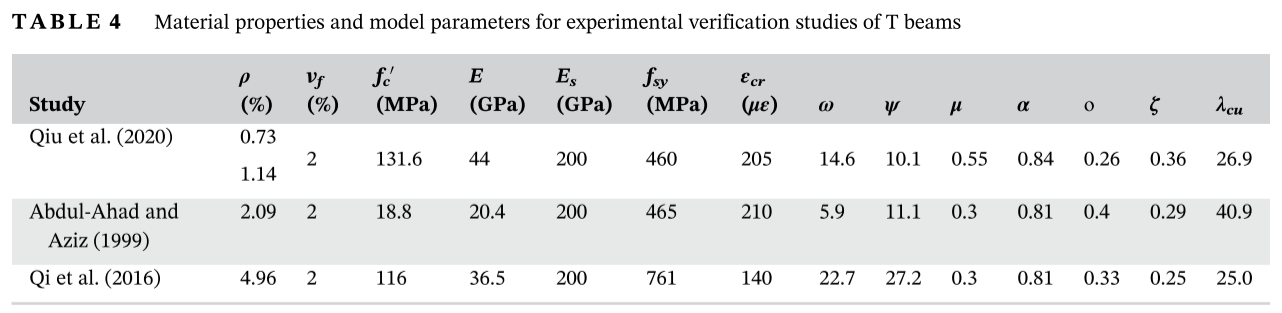

In [ ]:
def map_and_assign_params_for_t_section(
        mc, # MKappa instance for which the params should be applied
        b, h, E, E_s, f_sy, eps_cr, rho, beta_tu, v_f, omega, psi, mu, alpha, lambda_cu, o, zeta):
    """This function map the params of the rectangular section from the type of the paper
    to the type of the model and assigns the values"""
    t_shape = TShape(H= h, B_f = b, B_w = o*b, H_w = (1-zeta)*h)
    mc.cross_section_shape = t_shape
    
    mc.E_cc=E
    mc.E_ct=E # SUPPOSED equal to E_cc!!
    mc.mu=mu
    mc.eps_cr=eps_cr
    mc.eps_cy=omega * eps_cr
    mc.eps_cu=lambda_cu * eps_cr
    mc.eps_tu=beta_tu * eps_cr
    mc.eps_sy_j=[f_sy / E_s] # or eps_sy_j=psi * eps_cr,
    mc.E_j=[E_s]
    mc.z_j=[h * (1 - alpha)]
    mc.A_j=[rho * b * h]
    

In [10]:
def map_and_assign_params_for_rectangular_section(
        mc, # MKappa instance for which the params should be applied
        b, h, E, E_s, f_sy, eps_cr, rho, beta_tu, v_f, omega, psi, mu, alpha, lambda_cu):
    """This function map the params of the rectangular section from the type of the paper
    to the type of the model and assigns the values"""
    mc.cross_section_shape_.B=b
    mc.cross_section_shape_.H=h
    
    mc.cs_design.matrix='EC2'
    mc.cs_design.matrix_.trait_set(
            E_cc=E,
            E_ct=E,
            eps_cr=eps_cr,
            eps_tu=beta_tu * eps_cr,
            mu=mu,
            f_cm = f_cm
        )
    
    bl1 = ReinfLayer(name='layer')
    bl1.trait_set(z=h * (1 - alpha), A=rho * b * alpha * h)
    bl1.matmod_.trait_set(E_s=E_s, f_sy=f_sy)
    mc.cross_section_layout.add_layer(bl1)

Notation in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404) | Notation in this file
----------- | -----------
$E$      | E_ct
$E_c$   | E_cc
$E_s$ | E_j
$\varepsilon_{cr}$ | eps_cr
$\varepsilon_{cu}$ | eps_cu
$\varepsilon_{tu}$ | eps_tu
$\varepsilon_{cy}$ | eps_cy
$\mu$ | mu
$\gamma$  | E_cc/E_ct
$\omega$  | eps_cy/eps_cr
$\lambda_{cu}$  | eps_cu/eps_cr
$\beta_{tu}$  | eps_tu/eps_cr
$\psi$  | eps_sy_j/eps_cr
$n$  | E_j/E_ct
$\alpha$  | z_j/h
$r$  | A_s_c/A_s_t
$\rho_g$ | A_j[0]/A_c, where A_j[0] must be tension steel area

### Verification with Rectangluar cross sections
In the following verifications, the parameters will be taken from the parameters summary in Table 3 in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404)
And the following functions is provided to map the params in the format used in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404) to the format of the Deflection model

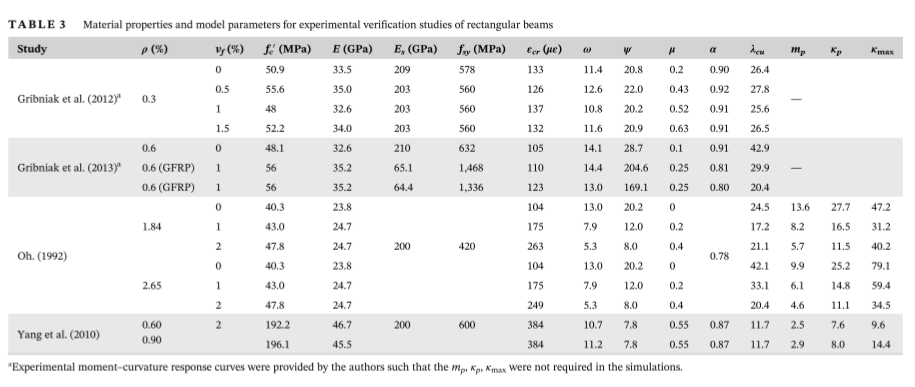